# Integrating arbitrary ODEs

Although REBOUND is primarily an N-body integrator, it can also integrate arbitrary ordinary differential equations (ODEs). Even better: it can integrate arbitrary ODEs in parallel with an N-body simulation. This allows you to couple various physical effects such as spin and tides to orbital dynamics.

In this example, we are integrating a two planet system and a decoupled harmonic oscillator which is governed by the following ODE:

$$ y_0(t)'' = -\frac km y_0(t)$$

or equivalently as a set of 2 first order differential equations

$$         \begin{pmatrix} y_0(t)\\y_1(t)\end{pmatrix}' =  \begin{pmatrix} y_1(t)\\- \frac k m y_0(t)\end{pmatrix}
$$

In [1]:
import rebound
import numpy as np
import matplotlib.pyplot as plt

We first set up our N-body simulation. Note that we are using the Gragg-Bulirsch-Stoer integrator (BS).

In [2]:
sim = rebound.Simulation()
sim.add(m=1)
sim.add(a=1.2,m=1e-3,e=0.1)
sim.add(a=2.3,m=1e-3,e=0.1)
sim.integrator = "BS"

We now create an ODE structure. Note that the ODE is linked to the simulation. If you run multiple simulations in parallel, you need to create an ode structure for each of them.

In [3]:
ode_ho = sim.create_ode(length=2, needs_nbody=False)

Next, we setup the ODE structure with the initial conditions and the right hand side (RHS) of the harmonic oscillator:

In [4]:
# Mass and spring constants
m = 1.
k = 10.

# Initial conditions
ode_ho.y[0] = 1. 
ode_ho.y[1] = 0. # zero velocity

# RHS
def derivatives_ho(ode, yDot, y, t):
    yDot[0] = y[1]
    yDot[1] = -k/m*y[0]

ode_ho.derivatives = derivatives_ho    

To keep track of how accurate the integration of the harmonic oscillator is, we can calculate the energy which is conserved in the physical system.

In [5]:
def energy_ho(ode):
    return 0.5*k*ode.y[0]**2 + 0.5*m*ode.y[1]**2

Now we can run the simulation, keeping track of a few quantities along the way.

In [6]:
times = np.linspace(0.,60.,1000)
energies_nbody = np.zeros(len(times))
energies_ho = np.zeros(len(times))
r_nbody = np.zeros(len(times))
x_ho = np.zeros(len(times))

for i, t in enumerate(times):
    sim.integrate(t)
    
    r_nbody[i] = sim.particles[1].d
    x_ho[i] = ode_ho.y[0]
    energies_nbody[i] = sim.energy()
    energies_ho[i] = energy_ho(ode_ho)

Let's plot the relative energy error over time for both the N-body and the harmonic oscillator integration.

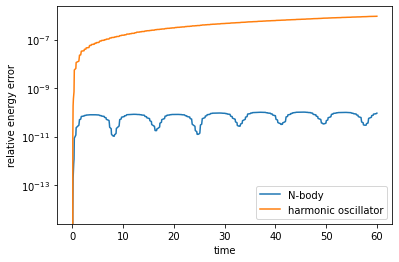

In [7]:
fig, ax = plt.subplots(1,1)
ax.set_xlabel("time")
ax.set_ylabel("relative energy error")
ax.set_yscale("log")
ax.plot(times,np.abs((energies_nbody-energies_nbody[0])/energies_nbody[0]), label="N-body")
ax.plot(times,np.abs((energies_ho-energies_ho[0])/energies_ho[0]), label="harmonic oscillator")
ax.legend()

Let us also plot the radius of the inner planet and the position coordinate of the harmonic oscillator.

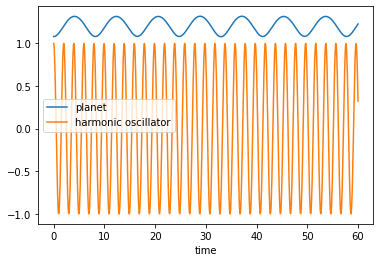

In [8]:
fig, ax = plt.subplots(1,1)
ax.set_xlabel("time")
ax.plot(times,r_nbody, label="planet")
ax.plot(times,x_ho, label="harmonic oscillator")
ax.legend()

The above example is using the BS integrator for both the N-body and the harmonic oscillator integration. The BS integrator has default tolerance parameters set to $10^{-5}$. You can change the relative or absolute tolerance with to get more accurate results:

In [9]:
sim.ri_bs.eps_rel = 1e-8
sim.ri_bs.eps_abs = 1e-8

Note that in this example, the harmonic oscillator has a period that is shorter than any orbital timescale. Therefore the timestep is limited by the harmonic oscillator, not the N-body integration. As a result, the N-body integration has an error much smaller than the tolerance parameters.  

Let us change the simple harmonic oscillator to a forced harmonic oscillator where the forcing depends on phase of a planet.

In [10]:
def derivatives_ho_forced(ode, yDot, y, t):
    # Now we can access particles and their orbital parameters during sub-steps
    forcing = np.sin(sim.particles[1].f)
    
    # Note that we are using the global sim variable.
    # Alternatively, one can also access the simulation via
    # sim = ode.contents.r.contents 
    
    yDot[0] = y[1]
    yDot[1] = -k/m*y[0] + forcing

ode_ho.derivatives = derivatives_ho_forced

We explicitly set `needs_nbody = False` during initialization. We therefore need to tell REBOUND that our ODE now needs access to the particle state during the integrations:

In [11]:
ode_ho.needs_nbody = True

Running the integration a bit further, now with the forced harmonic oscillator:

In [12]:
times = np.linspace(65.,120.,1000)

for i, t in enumerate(times):
    sim.integrate(t)
    
    r_nbody[i] = sim.particles[1].d
    x_ho[i] = ode_ho.y[0]
    energies_nbody[i] = sim.energy()
    energies_ho[i] = energy_ho(ode_ho)

The harmonic oscillator is now getting forced by the planet.

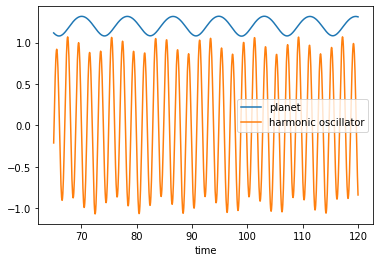

In [13]:
fig, ax = plt.subplots(1,1)
ax.set_xlabel("time")
ax.plot(times,r_nbody, label="planet")
ax.plot(times,x_ho, label="harmonic oscillator")
ax.legend()

In addition to using BS, it is also possible to integrate arbitrary ODEs in conjunction with other REBOUND integrators such as IAS15 and WHFast. In that case, only the user-defined ODEs are integrated with BS **after** a successfull N-body integration step. This type of switching back and forth the different ODEs will lead to an error. However, if the timescale involved in the user-defined ODEs are much longer than the timestep of the N-body integration, then this will be a small error. 